In [124]:
%pip install bitarray
%pip install levenshtein
%pip install torch
%pip install torchvision
%pip install torchaudio
%pip install lightning 
%pip install pandas
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import random
import torch

In [2]:
# https://github.com/manassra/LZ77-Compressor
from bitarray import bitarray


class LZ77Compressor:
    """
    A simplified implementation of the LZ77 Compression Algorithm
    """
    MAX_WINDOW_SIZE = 400

    def __init__(self, window_size=20):
        self.window_size = min(window_size, self.MAX_WINDOW_SIZE)
        self.lookahead_buffer_size = 15  # length of match is at most 4 bits

    def compress(self, input_file_path, output_file_path=None, verbose=False):
        """
        Given the path of an input file, its content is compressed by applying a simple
        LZ77 compression algorithm.

        The compressed format is:
        0 bit followed by 8 bits (1 byte character) when there are no previous matches
            within window
        1 bit followed by 12 bits pointer (distance to the start of the match from the
            current position) and 4 bits (length of the match)

        If a path to the output file is provided, the compressed data is written into
        a binary file. Otherwise, it is returned as a bitarray

        if verbose is enabled, the compression description is printed to standard output
        """
        data = None
        i = 0
        output_buffer = bitarray(endian='big')

        # read the input file
        try:
            with open(input_file_path, 'rb') as input_file:
                data = input_file.read()
        except IOError:
            print('Could not open input file ...')
            raise

        while i < len(data):
            # print(i)

            match = self.findLongestMatch(data, i)

            if match:
                # Add 1 bit flag, followed by 12 bit for distance, and 4 bit for the length
                # of the match
                (bestMatchDistance, bestMatchLength) = match

                output_buffer.append(True)
                output_buffer.frombytes(bytes([bestMatchDistance >> 4]))
                output_buffer.frombytes(bytes([((bestMatchDistance & 0xf) << 4) | bestMatchLength]))

                if verbose:
                    print("<1, %i, %i>" % (bestMatchDistance, bestMatchLength), end='')

                i += bestMatchLength

            else:
                # No useful match was found. Add 0 bit flag, followed by 8 bit for the character
                output_buffer.append(False)
                output_buffer.frombytes(bytes([data[i]]))

                if verbose:
                    print("<0, %s>" % data[i], end='')

                i += 1

        # fill the buffer with zeros if the number of bits is not a multiple of 8
        output_buffer.fill()

        # write the compressed data into a binary file if a path is provided
        if output_file_path:
            try:
                with open(output_file_path, 'wb') as output_file:
                    output_file.write(output_buffer.tobytes())
                    print("File was compressed successfully and saved to output path ...")
                    return None
            except IOError:
                print('Could not write to output file path. Please check if the path is correct ...')
                raise

        # an output file path was not provided, return the compressed data
        return output_buffer

    def findLongestMatch(self, data, current_position):
        """
        Finds the longest match to a substring starting at the current_position
        in the lookahead buffer from the history window
        """
        end_of_buffer = min(current_position + self.lookahead_buffer_size, len(data) + 1)

        best_match_distance = -1
        best_match_length = -1

        # Optimization: Only consider substrings of length 2 and greater, and just
        # output any substring of length 1 (8 bits uncompressed is better than 13 bits
        # for the flag, distance, and length)
        for j in range(current_position + 2, end_of_buffer):

            start_index = max(0, current_position - self.window_size)
            substring = data[current_position:j]

            for i in range(start_index, current_position):

                repetitions = len(substring) // (current_position - i)

                last = len(substring) % (current_position - i)

                matched_string = data[i:current_position] * repetitions + data[i:i + last]

                if matched_string == substring and len(substring) > best_match_length:
                    best_match_distance = current_position - i
                    best_match_length = len(substring)

        if best_match_distance > 0 and best_match_length > 0:
            return (best_match_distance, best_match_length)
        return None

    def compress_in_place(self, data, verbose=False):
        """
        Given the path of an input file, its content is compressed by applying a simple
        LZ77 compression algorithm.

        The compressed format is:
        0 bit followed by 8 bits (1 byte character) when there are no previous matches
            within window
        1 bit followed by 12 bits pointer (distance to the start of the match from the
            current position) and 4 bits (length of the match)

        If a path to the output file is provided, the compressed data is written into
        a binary file. Otherwise, it is returned as a bitarray

        if verbose is enabled, the compression description is printed to standard output
        """
        i = 0
        output_buffer = bitarray(endian='big')

        while i < len(data):

            # print(i)

            match = self.findLongestMatch(data, i)

            if match:
                # Add 1 bit flag, followed by 12 bit for distance, and 4 bit for the length
                # of the match
                (bestMatchDistance, bestMatchLength) = match

                output_buffer.append(True)
                output_buffer.frombytes(bytes([bestMatchDistance >> 4]))
                output_buffer.frombytes(bytes([((bestMatchDistance & 0xf) << 4) | bestMatchLength]))

                if verbose:
                    print("<1, %i, %i>" % (bestMatchDistance, bestMatchLength), end='')

                i += bestMatchLength

            else:
                # No useful match was found. Add 0 bit flag, followed by 8 bit for the character
                output_buffer.append(False)
                output_buffer.frombytes(bytes([data[i]]))

                if verbose:
                    print("<0, %s>" % data[i], end='')

                i += 1

        # fill the buffer with zeros if the number of bits is not a multiple of 8
        output_buffer.fill()

        # an output file path was not provided, return the compressed data
        return output_buffer

if __name__ == '__main__':
    compressor = LZ77Compressor()
    data = b"3C[33[[3[[[[5[[[[[3[[[[L+q[[[[I[[[P333N["
    print(compressor.compress_in_place(data))


bitarray('00011001100100001100101101100011001100011001100101101110000000001000010100000000001100101000000000101001000011010110000000001010100100000000101101100010011000001010110011100011000000010010010000100100110000000100100011001010000000110011100000000000100100010011100010110110')


In [3]:
import string

def generate_random_ascii_bytes(length, repetition_probability=0.65):
    ascii_characters = string.ascii_letters + string.digits + string.punctuation
    dim = len(ascii_characters)
    random_ascii_text = ''

    for _ in range(length):
        if random.random() < repetition_probability and random_ascii_text:
            # Répétition d'un caractère existant
            random_ascii_text += random.choice(random_ascii_text)
        else:
            # Choix aléatoire d'un nouveau caractère
            random_ascii_text += random.choice(ascii_characters)

    # Convertir la chaîne de caractères en bytes en utilisant encode
    random_ascii_bytes = random_ascii_text.encode('utf-8')
    return random_ascii_bytes, dim

def tokenizer(byte_tensor, length, device):
    """"
    :param byte_tensor: torch tensor uint8
    :param length: length of the output, complete with padding if shorter
    :return: torch tensor int16
    """
    new_tensor = (byte_tensor[:length] + 1)
    zero_tensor = torch.zeros(length, dtype=torch.int64).to(device)
    zero_tensor[:new_tensor.size(0)] = new_tensor

    return zero_tensor

def bytes2torch(bytes):
    if not type(bytes) is list:
        data_integers = list(bytes)

    data_tensor = torch.tensor(data_integers, dtype=torch.uint8)

    return data_tensor


In [4]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class LZ77Dataset(Dataset):
    def __init__(self, length, device, features_folder="./data_LZ77/text", targets_folder="./data_LZ77/compress",
                 transform=None):
        
        self.features_folder = features_folder
        self.targets_folder = targets_folder
        self.transform = transform
        self.length = length # max length
        self.device = device

        # Listes des noms de fichiers dans les dossiers
        self.feature_files = os.listdir(features_folder)
        self.target_files = os.listdir(targets_folder)

    def __len__(self):
        return min(len(self.feature_files), len(self.target_files))

    def __getitem__(self, idx):
        feature_path = os.path.join(self.features_folder, self.feature_files[idx])
        target_path = os.path.join(self.targets_folder, self.target_files[idx])

        with open(feature_path, 'rb') as feature_file:
            feature_data = feature_file.read()
        with open(target_path, 'rb') as target_file:
            target_data = target_file.read()

        if self.transform:
            pass

        feature_data = tokenizer(bytes2torch(feature_data), self.length, self.device)
        target_data = tokenizer(bytes2torch(target_data), self.length, self.device)

        return feature_data, target_data


In [5]:
import os
from torch.utils.data import Dataset, DataLoader

def create_sample_in_place(compressor, length, repetition_probability):
    text, dim = generate_random_ascii_bytes(length, repetition_probability)
    compress = compressor.compress_in_place(text)

    return text, compress

def bits_to_bytes(bits):
    return bits.tobytes()


class LZ77Dataset_current_creation(Dataset):
    def __init__(self, length_sentence, device, repetition_probability, size_data_set, lenght_max):
        self.compressor = LZ77Compressor()
        self.length_sentence = length_sentence
        self.device = device
        self.repetition_probability = repetition_probability
        self.size_data_set = size_data_set
        self.lenght_max = lenght_max

    def __len__(self):
        return self.size_data_set

    def __getitem__(self, idx):
        text, compress = create_sample_in_place(self.compressor, self.length_sentence, self.repetition_probability)

        feature_data = tokenizer(bytes2torch(text), self.lenght_max, self.device)
        target_data = tokenizer(bytes2torch(bits_to_bytes(compress)), self.lenght_max, self.device)

        return feature_data, target_data


In [6]:
def get_dataloader_compression(batch_size, device, train_dataset, test_dataset):
    lz77_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    lz77_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    encoding_byte_size = 255
    n_context_word = 2

    n_input_word = encoding_byte_size + n_context_word
    n_output_word = n_input_word

    return n_input_word, n_output_word, lz77_train_loader, lz77_test_loader

In [7]:
import torch.nn as nn
import torch.nn.functional as F

SOS_token = 0


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size + 1, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

MAX_LENGTH = 10

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.2):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [10]:
import torch
import torchaudio

def levenshtein(encoder, decoder, batch):
    encoder.eval()
    decoder.eval()
    total_distance, count = 0, 0
    with torch.no_grad():
        feature, target = batch[0], batch[1]
        encoder_outputs, encoder_hidden = encoder(feature)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        
        decoded_ids = topi.squeeze().tolist()  # Convert to list of indices
        target_ids = target.tolist()  # Convert target tensor to list

        # Calculate edit distance for each sequence in the batch
        for decoded_seq, target_seq in zip(decoded_ids, target_ids):
            total_distance += torchaudio.functional.edit_distance(decoded_seq, target_seq)
            count += 1

    return total_distance / count if count > 0 else 0


def unzip(encoder, decoder, batch):
    device = next(encoder.parameters()).device  # Get device model
    encoder.eval()
    decoder.eval()
    good, count = 0, 0
    with torch.no_grad():
        feature, target = batch[0].to(device), batch[1].to(device)
        encoder_outputs, encoder_hidden = encoder(feature)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        if torch.equal(decoded_ids, target):
            good += 1
        count += 1

    return good / count if count > 0 else 0



In [11]:
# import levenshtein
import torchaudio

def levenshtein_value(encoder,decoder, test_dataloader):
  count = 0
  good = 0

  for batch in (test_dataloader):
    for i in range(batch[0].shape[0]):

      feature = batch[0][i].unsqueeze(0)
      target = batch[1][i]

      encoder_outputs, encoder_hidden = encoder(feature)
      decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

      _, topi = decoder_outputs.topk(1)
      decoded_ids = topi.squeeze()

      good +=  torchaudio.functional.edit_distance(decoded_ids, target)

      count+=1

  return good/count


def zip_value(encoder,decoder, test_dataloader):
  count = 0
  good = 0

  for batch in test_dataloader:
    for i in range(batch[0].shape[0]):

      feature = batch[0][i].unsqueeze(0)
      target = batch[1][i]

      encoder_outputs, encoder_hidden = encoder(feature)
      decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

      _, topi = decoder_outputs.topk(1)
      decoded_ids = topi.squeeze()

      if torch.equal(decoded_ids, target):
        good += 1

      count+=1

  return good/count

## Seq2Seq Module

In [12]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModule(pl.LightningModule):
    def __init__(self, encoder, decoder, criterion, lr=1e-3):
        super(Seq2SeqModule, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.criterion = criterion
        self.lr = lr
        
        # RuntimeError: Training with multiple optimizers is only supported with manual optimization. 
        self.automatic_optimization = False  

    def forward(self, input_tensor, target_tensor):
        # Forward pass through encoder and decoder
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)
        return decoder_outputs

    def training_step(self, batch, batch_idx):
        input_tensor, target_tensor = batch
        encoder_optimizer, decoder_optimizer = self.optimizers()
    
        # Réinitialisation des gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = self.encoder(input_tensor)

        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = self.criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss}

    def configure_optimizers(self):
        decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.lr)
        encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.lr)
        return encoder_optimizer, decoder_optimizer

    # Save model
    def save_model(self, file_path):
        self.trainer.save_checkpoint(file_path)

    # Static method to load model
    @staticmethod
    def load_model(file_path, encoder, decoder, criterion):
        return Seq2SeqModule.load_from_checkpoint(checkpoint_path=file_path,
                                                  encoder=encoder,
                                                  decoder=decoder,
                                                  criterion=criterion)


In [13]:
# Delete checkpoint files
!rm *.ckpt
!rm metrics.csv

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [46]:
from pytorch_lightning.callbacks import Callback
import csv
import os

class MetricsLogger(Callback):
    def __init__(self, save_path="metrics.csv", period=100, test_dataloader=None, train_dataloader=None):
        self.save_path = save_path
        self.period = period
        self.test_dataloader = test_dataloader
        self.train_dataloader = train_dataloader

    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch) % self.period == 0:
            metrics = trainer.callback_metrics
            unzip_score_test = zip_value(pl_module.encoder, pl_module.decoder, self.test_dataloader)
            levenshtein_score_test = levenshtein_value(pl_module.encoder, pl_module.decoder, self.test_dataloader)
            
            unzip_score_train = zip_value(pl_module.encoder, pl_module.decoder, self.train_dataloader)
            levenshtein_score_train = levenshtein_value(pl_module.encoder, pl_module.decoder, self.train_dataloader)
            print(f"Epoch Loss train : {metrics.get('train_loss', 0).item()} \
             | Levenshtein train: {levenshtein_score_train} | Unzip train: {unzip_score_train}\
             | Levenshtein test: {levenshtein_score_test} | Unzip test: {unzip_score_test}     ")
            
            row = {
                'epoch': trainer.current_epoch,
                'train_loss': metrics.get('train_loss', 0).item(),
                'levenshtein_score_train': levenshtein_score_train,
                'unzip_score_train': unzip_score_train,
                'levenshtein_score_test': levenshtein_score_test,
                'unzip_score_test': unzip_score_test,
            }
            file_exists = os.path.isfile(self.save_path)
            with open(self.save_path, mode='a', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=row.keys())
                if not file_exists:
                    writer.writeheader()  # Write header only once
                writer.writerow(row)



## Instantiate model and train with Lightning

In [47]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split


lenght_max = MAX_LENGTH
length_sentence = lenght_max-3
batch_size = 100
hidden_size = 128
device = "cpu"
repetition_probability = 0.8
size_data_set = 1000
n_epochs = 4000
log_period = 50


lz77_dataset =LZ77Dataset(MAX_LENGTH, device)
# lz77_dataset = LZ77Dataset_current_creation(length_sentence, device, repetition_probability, size_data_set, lenght_max)
test_size = int(0.2 * len(lz77_dataset))

train_dataset, test_dataset = random_split(lz77_dataset, [len(lz77_dataset) - test_size, test_size])

n_input_word, n_output_word, train_dataloader, test_dataloader = get_dataloader_compression(batch_size, device, train_dataset, test_dataset)

# Instantiate the models and criterion
encoder = EncoderRNN(n_input_word, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, n_output_word).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# Create the Seq2Seq Lightning module
model = Seq2SeqModule(encoder, decoder, criterion)

# Create a model checkpoint to save regularly the training progression
checkpoint_callback = ModelCheckpoint(
    dirpath="",
    filename="model_{epoch:02d}_epochs",
    verbose=True,
    save_top_k=-1,  # we keep all of them
    every_n_epochs=n_epochs//10,
)

# Create a PyTorch Lightning trainer
trainer = Trainer(
    max_epochs=n_epochs+1,
    callbacks=[checkpoint_callback, MetricsLogger(save_path="metrics.csv", period=log_period, test_dataloader=test_dataloader, train_dataloader= train_dataloader)],
    accelerator=device,
)

# Start training
trainer.fit(model, train_dataloader, test_dataloader)

# Save model
# model_name = f"model_{n_epochs}_epochs.pt"
# model.save_model(model_name)



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\aymeric\miniconda3\envs\ReinforLearning\Lib\site-packages\pytorch_lightning\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
C:\Users\aymeric\miniconda3\envs\ReinforLearning\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
C:\Users\aymeric\miniconda3\envs\ReinforLearning\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory  exists and is not empty.

  | Name      | Type           | Params
---------------------------------------------
0 | encoder   | EncoderRNN     | 132 K 
1 | decoder   | AttnDecoderRNN | 247 K 
2 | criterion | NLLLoss        | 0     
---------------------------------------------
379 K     Trainable params
0   

Training: |          | 0/? [00:00<?, ?it/s]

Epoch Loss train : 5.383274555206299              | Levenshtein train: 8.1375 | Unzip train: 0.0             | Levenshtein test: 8.105 | Unzip test: 0.0     
Epoch Loss train : 0.898867666721344              | Levenshtein train: 3.75125 | Unzip train: 0.2025             | Levenshtein test: 6.41 | Unzip test: 0.055     
Epoch Loss train : 0.15351779758930206              | Levenshtein train: 0.105 | Unzip train: 0.9575             | Levenshtein test: 6.285 | Unzip test: 0.08     
Epoch Loss train : 0.04843248054385185              | Levenshtein train: 0.00375 | Unzip train: 0.9975             | Levenshtein test: 6.42 | Unzip test: 0.075     
Epoch Loss train : 0.022669613361358643              | Levenshtein train: 0.0 | Unzip train: 1.0             | Levenshtein test: 6.3 | Unzip test: 0.075     
Epoch Loss train : 0.013808989897370338              | Levenshtein train: 0.0025 | Unzip train: 0.99625             | Levenshtein test: 6.395 | Unzip test: 0.08     
Epoch Loss train : 0.008718

C:\Users\aymeric\miniconda3\envs\ReinforLearning\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Training from Checkpoint

In [17]:
from pytorch_lightning import Trainer

checkpoint_path = f'checkpoints/model_epoch={n_epochs-1}_epochs.ckpt'

trainer = Trainer(
    resume_from_checkpoint=checkpoint_path,
    max_epochs=7000, 
)
trainer.fit(model, train_dataloader, test_dataloader)


TypeError: Trainer.__init__() got an unexpected keyword argument 'resume_from_checkpoint'

## Evaluation

In [48]:
encoder.eval()
decoder.eval()
unzip_metric = zip_value(model.encoder, model.decoder, test_dataloader)

print(unzip_metric)

0.08


In [50]:
encoder.eval()
decoder.eval()
encoder_raw = EncoderRNN(n_input_word, hidden_size).to(device)
decoder_raw = AttnDecoderRNN(hidden_size, n_output_word).to(device)

batch = next(iter(test_dataloader))
feature = batch[0][0].unsqueeze(0)
target = batch[1][0]
print("Target:", target)


# Raw
encoder_outputs, encoder_hidden = encoder_raw(feature)
decoder_outputs, decoder_hidden, decoder_attn = decoder_raw(encoder_outputs, encoder_hidden)
_, topi = decoder_outputs.topk(1)
decoded_ids = topi.squeeze()
print("Decoded (raw):", decoded_ids)

# Model
encoder_outputs, encoder_hidden = model.encoder(feature)
decoder_outputs, decoder_hidden, decoder_attn = model.decoder(encoder_outputs, encoder_hidden)

_, topi = decoder_outputs.topk(1)
decoded_ids = topi.squeeze()

print("Decoded (model):", decoded_ids)

Target: tensor([ 31,  20, 200, 132, 195,  26,  15,   1, 198,   1])
Decoded (raw): tensor([217,  83,  68, 238, 222,  86,  42, 216,   6, 242])
Decoded (model): tensor([ 31,  16,  11, 135,  84,  57,   1,  73,   2, 201])


## Plot results

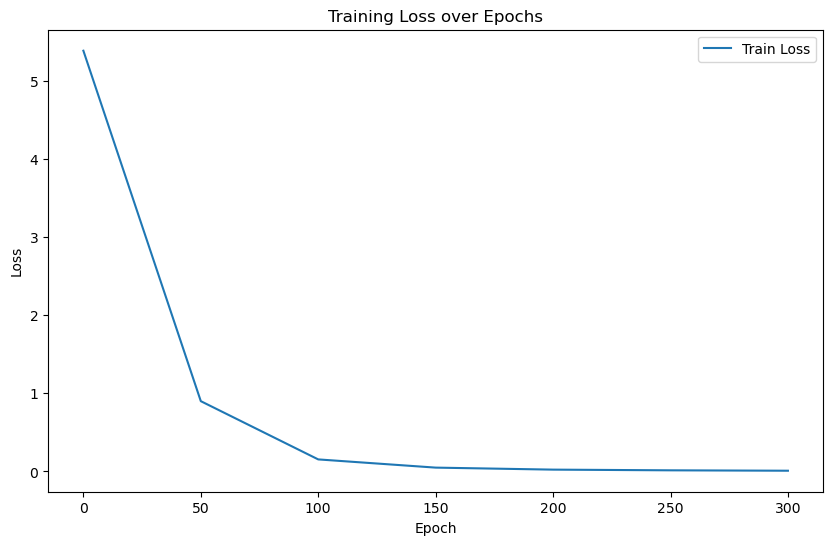

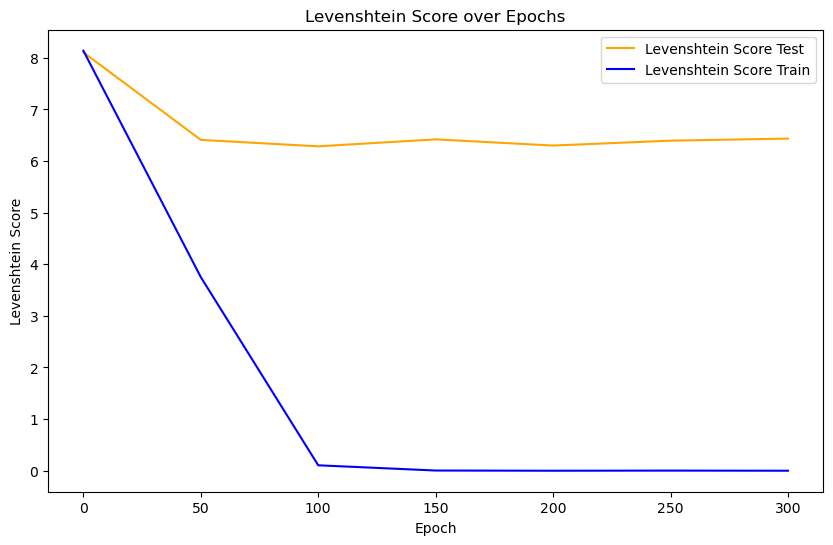

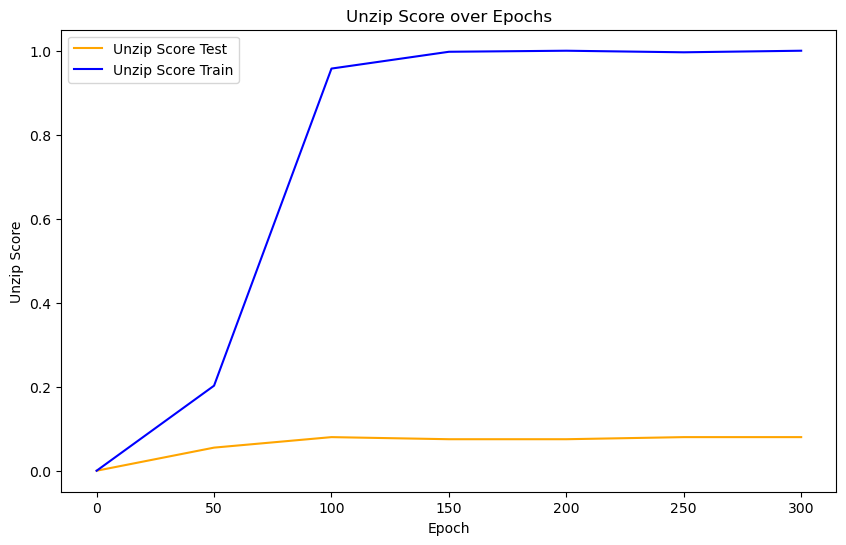

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Lire les données depuis le fichier CSV
metrics_df = pd.read_csv('metrics.csv')

# Afficher les premières lignes pour vérifier
# print(metrics_df.head())


# Tracer la loss d'entraînement
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Tracer la métrique de Levenshtein
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['levenshtein_score_test'], label='Levenshtein Score Test', color='orange')
plt.plot(metrics_df['epoch'], metrics_df['levenshtein_score_train'], label='Levenshtein Score Train', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Levenshtein Score')
plt.title('Levenshtein Score over Epochs')
plt.legend()
plt.show()

# Tracer la métrique de Unzip
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['epoch'], metrics_df['unzip_score_test'], label='Unzip Score Test', color='orange')
plt.plot(metrics_df['epoch'], metrics_df['unzip_score_train'], label='Unzip Score Train', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Unzip Score')
plt.title('Unzip Score over Epochs')
plt.legend()
plt.show()
